In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from pyuoi.linear_model.var import VAR

In [5]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes
from decoders import lr_decoder
from utils import apply_df_filters

In [100]:
# Time scale analysis: 
# A few questions:
# (1) Use the subspaces derived at fast timescales to assess coupling/decoding at slower/the same timescales
# (2) Use subspaces derived at slow timeslcaes to assess coupling/decoding at same/faster time scales
# (3) Types of analyses:
# (a) Decoding vs. dim, decoding vs. t --> By "decoding" at slower timescales, we could try some kind of smoothing
# (b) Time-resolved CCA, look at the different populations of neurons

### Preprocess and save

In [47]:
# Select the indy data file that has both M1/S1 and one loco datafile that seems to give decent decoding performance
data_files = ['/mnt/Secondary/data/sabes/indy_20160426_01.mat', '/mnt/Secondary/data/sabes/loco_20170227_04.mat']

In [9]:

# Collect into bin width and filter param tuples

processing_params = [
    # Baseline - non-overlapping windows with no window
    (5, dict(filter_fn='none', filter_kwargs={})),
    (10, dict(filter_fn='none', filter_kwargs={})),
    (15, dict(filter_fn='none', filter_kwargs={})),
    (25, dict(filter_fn='none', filter_kwargs={})),
    (50, dict(filter_fn='none', filter_kwargs={})),

    # Narrow bins with smoothing timescales
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),


    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    # Narrow bins with boxcar filter of various widths
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),

    # Hann windows
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),
]

for didx, data_file in enumerate(data_files):
    for i, loader_param in tqdm(enumerate(processing_params)):
        if os.path.exists('/mnt/Secondary/data/sabes_tmp/didx_%d_loader_idx_%d.pkl' % (didx, i)):
            print('Skipping')
            continue
        else:
            print('Loading M1')
            datM1 = load_sabes(data_file, bin_width=loader_param[0], filter_fn=loader_param[1]['filter_fn'], filter_kwargs=loader_param[1]['filter_kwargs'], region='M1')
            print('Loading S1')
            datS1 = load_sabes(data_file, bin_width=loader_param[0], filter_fn=loader_param[1]['filter_fn'], filter_kwargs=loader_param[1]['filter_kwargs'], region='S1')

            # Save away with the loader parameters
            with open('/mnt/Secondary/data/sabes_tmp/didx_%d_loader_idx_%d.pkl' % (didx, i), 'wb') as f:
                f.write(pickle.dumps(datM1))
                f.write(pickle.dumps(datS1))
                f.write(pickle.dumps(loader_param))

0it [00:00, ?it/s]

Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Loading M1
Loading S1
96


15it [03:36, 14.41s/it]

Loading M1
Loading S1
96


16it [07:12, 32.01s/it]

Loading M1
Loading S1
96


17it [10:47, 52.20s/it]

Loading M1
Loading S1
96


18it [12:35, 59.77s/it]

Loading M1
Loading S1
96


19it [14:23, 67.60s/it]

Loading M1
Loading S1
96


20it [16:11, 75.19s/it]

Loading M1
Loading S1
96


21it [16:54, 68.47s/it]

Loading M1
Loading S1
96


22it [17:37, 62.63s/it]

Loading M1
Loading S1
96


23it [18:22, 58.00s/it]

Loading M1
Loading S1
96


24it [21:56, 99.25s/it]

Loading M1
Loading S1
96


25it [25:30, 130.53s/it]

Loading M1
Loading S1
96


26it [29:05, 154.07s/it]

Loading M1
Loading S1
96


27it [30:52, 140.68s/it]

Loading M1
Loading S1
96


28it [32:39, 130.84s/it]

Loading M1
Loading S1
96


29it [34:27, 124.14s/it]

Loading M1
Loading S1
96


30it [35:10, 100.40s/it]

Loading M1
Loading S1
96


31it [35:54, 83.54s/it] 

Loading M1
Loading S1
96


32it [36:37, 68.68s/it]
0it [00:00, ?it/s]

Loading M1
Loading S1
96


1it [04:12, 252.28s/it]

Loading M1
Loading S1
96


2it [06:18, 178.21s/it]

Loading M1
Loading S1
96


3it [07:42, 135.23s/it]

Loading M1
Loading S1
96


4it [08:34, 102.31s/it]

Loading M1
Loading S1
96


5it [09:00, 74.64s/it] 

Loading M1
Loading S1
96


6it [13:15, 136.06s/it]

Loading M1
Loading S1
96


7it [17:30, 175.04s/it]

Loading M1
Loading S1
96


8it [21:47, 201.13s/it]

Loading M1
Loading S1
96


9it [23:55, 178.34s/it]

Loading M1
Loading S1
96


10it [26:04, 163.00s/it]

Loading M1
Loading S1
96


11it [28:13, 152.54s/it]

Loading M1
Loading S1
96


12it [29:05, 121.84s/it]

Loading M1
Loading S1
96


13it [29:57, 100.83s/it]

Loading M1
Loading S1
96


14it [30:49, 86.00s/it] 

Loading M1
Loading S1
96


15it [35:03, 136.79s/it]

Loading M1
Loading S1
96


16it [39:18, 172.28s/it]

Loading M1
Loading S1
96


17it [43:33, 197.21s/it]

Loading M1
Loading S1
96


18it [45:41, 176.41s/it]

Loading M1
Loading S1
96


19it [47:49, 161.90s/it]

Loading M1
Loading S1
96


20it [49:56, 151.38s/it]

Loading M1
Loading S1
96


21it [50:47, 121.33s/it]

Loading M1
Loading S1
96


22it [51:40, 100.65s/it]

Loading M1
Loading S1
96


23it [52:32, 86.15s/it] 

Loading M1
Loading S1
96


24it [56:46, 136.33s/it]

Loading M1
Loading S1
96


25it [1:00:59, 171.51s/it]

Loading M1
Loading S1
96


26it [1:05:14, 196.62s/it]

Loading M1
Loading S1
96


27it [1:07:21, 175.79s/it]

Loading M1
Loading S1
96


28it [1:09:29, 161.36s/it]

Loading M1
Loading S1
96


29it [1:11:38, 151.45s/it]

Loading M1
Loading S1
96


30it [1:12:29, 121.44s/it]

Loading M1
Loading S1
96


31it [1:13:21, 100.59s/it]

Loading M1
Loading S1
96


32it [1:14:13, 139.16s/it]


In [50]:

# Collect into bin width and filter param tuples

processing_params = [
    # Baseline - non-overlapping windows with no window
    (5, dict(filter_fn='none', filter_kwargs={})),
    (10, dict(filter_fn='none', filter_kwargs={})),
    (15, dict(filter_fn='none', filter_kwargs={})),
    (25, dict(filter_fn='none', filter_kwargs={})),
    (50, dict(filter_fn='none', filter_kwargs={})),

    # Narrow bins with smoothing timescales
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),


    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    # Narrow bins with boxcar filter of various widths
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),

    # Hann windows
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),
]

for didx, data_file in enumerate(data_files):
    for i, loader_param in tqdm(enumerate(processing_params)):
        if os.path.exists('/mnt/Secondary/data/sabes_tmp/noboxcox/didx_%d_loader_idx_%d.pkl' % (didx, i)):
            print('Skipping')
            continue
        else:
            print('Loading M1')
            datM1 = load_sabes(data_file, bin_width=loader_param[0], 
                               filter_fn=loader_param[1]['filter_fn'], filter_kwargs=loader_param[1]['filter_kwargs'], region='M1', boxcox=None)
            print('Loading S1')
            datS1 = load_sabes(data_file, bin_width=loader_param[0], filter_fn=loader_param[1]['filter_fn'], 
                               filter_kwargs=loader_param[1]['filter_kwargs'], region='S1', boxcox=None)

            # Save away with the loader parameters
            with open('/mnt/Secondary/data/sabes_tmp/noboxcox/didx_%d_loader_idx_%d.pkl' % (didx, i), 'wb') as f:
                f.write(pickle.dumps(datM1))
                f.write(pickle.dumps(datS1))
                f.write(pickle.dumps(loader_param))

0it [00:00, ?it/s]

Loading M1
Loading S1
96


1it [00:22, 22.61s/it]

Loading M1
Loading S1
96


2it [00:34, 16.11s/it]

Loading M1
Loading S1
96


3it [00:42, 12.35s/it]

Loading M1
Loading S1
96


4it [00:47,  9.44s/it]

Loading M1
Loading S1
96


5it [00:49,  7.04s/it]

Loading M1
Loading S1
96


6it [01:12, 12.50s/it]

Loading M1
Loading S1
96


7it [01:36, 16.12s/it]

Loading M1
Loading S1
96


8it [02:00, 18.58s/it]

Loading M1
Loading S1
96


9it [02:12, 16.47s/it]

Loading M1
Loading S1
96


10it [02:24, 15.13s/it]

Loading M1
Loading S1
96


11it [02:36, 14.21s/it]

Loading M1
Loading S1
96


12it [02:41, 11.41s/it]

Loading M1
Loading S1
96


13it [02:46,  9.50s/it]

Loading M1
Loading S1
96


14it [02:51,  8.18s/it]

Loading M1
Loading S1
96


15it [03:14, 12.72s/it]

Loading M1
Loading S1
96


16it [03:38, 15.93s/it]

Loading M1
Loading S1
96


17it [04:01, 18.15s/it]

Loading M1
Loading S1
96


18it [04:13, 16.25s/it]

Loading M1
Loading S1
96


19it [04:25, 14.91s/it]

Loading M1
Loading S1
96


20it [04:37, 14.03s/it]

Loading M1
Loading S1
96


21it [04:42, 11.34s/it]

Loading M1
Loading S1
96


22it [04:47,  9.45s/it]

Loading M1
Loading S1
96


23it [04:52,  8.13s/it]

Loading M1
Loading S1
96


24it [05:15, 12.61s/it]

Loading M1
Loading S1
96


25it [05:38, 15.85s/it]

Loading M1
Loading S1
96


26it [06:02, 18.15s/it]

Loading M1
Loading S1
96


27it [06:14, 16.31s/it]

Loading M1
Loading S1
96


28it [06:26, 15.01s/it]

Loading M1
Loading S1
96


29it [06:38, 14.08s/it]

Loading M1
Loading S1
96


30it [06:43, 11.38s/it]

Loading M1
Loading S1
96


31it [06:48,  9.50s/it]

Loading M1
Loading S1
96


32it [06:53, 12.92s/it]
0it [00:00, ?it/s]

Loading M1
Loading S1
96


1it [00:33, 33.82s/it]

Loading M1
Loading S1
96


2it [00:50, 23.98s/it]

Loading M1
Loading S1
96


3it [01:02, 18.41s/it]

Loading M1
Loading S1
96


4it [01:09, 13.96s/it]

Loading M1
Loading S1
96


5it [01:13, 10.32s/it]

Loading M1
Loading S1
96


6it [01:48, 18.62s/it]

Loading M1
Loading S1
96


7it [02:23, 23.92s/it]

Loading M1
Loading S1
96


8it [02:58, 27.65s/it]

Loading M1
Loading S1
96


9it [03:16, 24.45s/it]

Loading M1
Loading S1
96


10it [03:33, 22.34s/it]

Loading M1
Loading S1
96


11it [03:51, 21.01s/it]

Loading M1
Loading S1
96


12it [03:59, 16.83s/it]

Loading M1
Loading S1
96


13it [04:06, 13.95s/it]

Loading M1
Loading S1
96


14it [04:14, 12.01s/it]

Loading M1
Loading S1
96


15it [04:48, 18.84s/it]

Loading M1
Loading S1
96


16it [05:23, 23.51s/it]

Loading M1
Loading S1
96


17it [05:57, 26.80s/it]

Loading M1
Loading S1
96


18it [06:14, 24.00s/it]

Loading M1
Loading S1
96


19it [06:32, 22.06s/it]

Loading M1
Loading S1
96


20it [06:49, 20.67s/it]

Loading M1
Loading S1
96


21it [06:57, 16.64s/it]

Loading M1
Loading S1
96


22it [07:04, 13.85s/it]

Loading M1
Loading S1
96


23it [07:11, 11.87s/it]

Loading M1
Loading S1
96


24it [07:46, 18.63s/it]

Loading M1
Loading S1
96


25it [08:20, 23.38s/it]

Loading M1
Loading S1
96


26it [08:55, 26.72s/it]

Loading M1
Loading S1
96


27it [09:12, 23.90s/it]

Loading M1
Loading S1
96


28it [09:30, 22.01s/it]

Loading M1
Loading S1
96


29it [09:47, 20.69s/it]

Loading M1
Loading S1
96


30it [09:54, 16.66s/it]

Loading M1
Loading S1
96


31it [10:02, 13.83s/it]

Loading M1
Loading S1
96


32it [10:09, 19.05s/it]


### Autocorrelation and Cross-Correlation Calculations

In [15]:
# Analysis #1: Effective single neuron autocorrelation times

In [6]:
fls = glob.glob('/mnt/Secondary/data/sabes_tmp/*.pkl')

In [7]:
acfl = []
for fl in tqdm(fls):
    r = {}
    r['didx'] = int(fl.split('didx_')[1].split('_')[0])
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)
    r['bin_width'] = lparam[0]
    r['filter_fn'] = lparam[1]['filter_fn']
    r['filter_kwargs'] = lparam[1]['filter_kwargs']

    XM1 = datM1['spike_rates'].squeeze()
    m1acf = []
    for j in range(XM1.shape[1]):
        m1acf.append(stattools.acf(XM1[:, j]))
    
    m1acf = np.array(m1acf).T

    XS1 = datS1['spike_rates'].squeeze()
    s1acf = []
    for j in range(XS1.shape[1]):
        s1acf.append(stattools.acf(XS1[:, j]))
    
    s1acf = np.array(s1acf).T

    r['M1acf'] = m1acf
    r['S1acf'] = s1acf
    acfl.append(r) 

100%|██████████| 64/64 [05:42<00:00,  5.36s/it]


In [8]:
with open('/home/akumar/nse/neural_control/data/timescales/acf.pkl', 'wb') as f:
    f.write(pickle.dumps(acfl))

In [6]:
import time

In [6]:
# Analysis 2: Cross-correlations between M1/S1 neurons
ccfl = []
for fl in tqdm(fls):
    r = {}
    r['didx'] = int(fl.split('didx_')[1].split('_')[0])
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)
    r['bin_width'] = lparam[0]
    r['filter_fn'] = lparam[1]['filter_fn']
    r['filter_kwargs'] = lparam[1]['filter_kwargs']

    XM1 = datM1['spike_rates'].squeeze()
    XS1 = datS1['spike_rates'].squeeze()

    x = np.hstack([XM1, XS1])
    ccm = calc_cross_cov_mats_from_data(x, 30, chunks=10)
    r['ccf'] = ccm
    ccfl.append(r) 

100%|██████████| 64/64 [1:59:04<00:00, 111.64s/it]


In [7]:
with open('/home/akumar/nse/neural_control/data/timescales/ccf.pkl', 'wb') as f:
    f.write(pickle.dumps(ccfl))

In [8]:
# Analysis 4: Canonical correlation analysis
ccal = []
lags = np.array([4, 2, 0])
windows = np.array([5, 3, 1])

for fl in tqdm(fls):
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    for k, lag in enumerate(lags):
        for w, window in enumerate(windows):
            t0 = time.time()
            r = {}
            r['didx'] = int(fl.split('didx_')[1].split('_')[0])
            r['bin_width'] = lparam[0]
            r['filter_fn'] = lparam[1]['filter_fn']
            r['filter_kwargs'] = lparam[1]['filter_kwargs']
            r['lag'] = lag
            r['win'] = w

            # Apply window and lag relative to each other
            if lag != 0:
                x = X[:-lag, :]
                y = Y[lag:, :]
            else:
                x = X
                y = Y

            if w > 1:
                x = form_lag_matrix(x, w)
                y = form_lag_matrix(y, w)

            ccamodel = CCA(n_components=6)
            ccamodel.fit(x, y)
            r['ccamodel'] = ccamodel
            ccal.append(r)
            print(time.time() - t0)            

  0%|          | 0/64 [00:00<?, ?it/s]

36.82945704460144
37.383957862854004
56.4776930809021


### Analysis

In [10]:
# CCA across timescales
fls = glob.glob('/mnt/Secondary/data/mpi_cc/*.pkl')

In [25]:
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break

In [27]:
df = pd.DataFrame(rl)

In [31]:
df.iloc[0]['fl']

'/mnt/Secondary/data/sabes_tmp/didx_0_loader_idx_0.pkl'

In [32]:
df.iloc[0]

didx                                                             0
bin_width                                                        5
filter_fn                                                     none
filter_kwargs                                                   {}
lag                                                              4
win                                                              0
ccamodel                                       CCA(n_components=6)
fl               /mnt/Secondary/data/sabes_tmp/didx_0_loader_id...
Name: 0, dtype: object

In [46]:
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()
Y.sha

(352411, 186)

In [176]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 6))
r2_scores = np.zeros(df.shape[0])
# These are the 

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)


    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [177]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [178]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df.pkl', 'wb') as f:
    f.write(pickle.dumps(df))

In [60]:
np.unique(df['filter_fn'].values)

array(['gaussian', 'none', 'window'], dtype=object)

In [ ]:
# Plot the canonical correlation coefficients as a function of the autocorrelation time of the window

In [67]:
df.iloc[24]

didx                                                             0
bin_width                                                       10
filter_fn                                                 gaussian
filter_kwargs                                         {'sigma': 5}
lag                                                              0
win                                                              0
ccamodel                                       CCA(n_components=6)
fl               /mnt/Secondary/data/sabes_tmp/didx_0_loader_id...
cc_coefs         [0.839197697302262, 0.6841652902187854, 0.5613...
Name: 24, dtype: object

In [65]:
g1 = scipy.signal.get_window(('gaussian',3), 100)
g2 = scipy.signal.get_window(('gaussian', 3), 20)

In [70]:
x = np.correlate(g1, g1, mode='full')

In [72]:
x = x[x.size//2:]

In [75]:
np.argwhere(x < 1e-2)[0][0]

16

In [80]:
# Window autocorrelation times

autocorr_times = np.zeros(df.shape[0])
for i in tqdm(range(df.shape[0])):

    window_type = df.iloc[i]['filter_fn']
    if window_type == 'window':
        window_type = df.iloc[i]['filter_kwargs']['window_name']

    if window_type == 'none':
        autocorr_times[i] = df.iloc[i]['bin_width']
    else:
        if window_type == 'gaussian':
            window = scipy.signal.get_window(('gaussian', df.iloc[i]['filter_kwargs']['sigma']), 100)
        else:
            window = scipy.signal.get_window(df.iloc[i]['filter_kwargs']['window_name'], 100)

        autocorr = np.correlate(window, window, mode='full')
        autocorr = autocorr[autocorr.size//2:]

        autocorr_times[i] = df.iloc[i]['bin_width'] * np.argwhere(autocorr <= 1e-2 * autocorr[0])[0][0]

100%|██████████| 576/576 [00:00<00:00, 4898.24it/s]


In [10]:
with open('/home/akumar/nse/neural_control/data/timescales/ccf.pkl', 'rb') as f:
    ccfl = pickle.load(f)

In [11]:
ccf_df = pd.DataFrame(ccfl)

In [90]:
np.array(ccf_df.iloc[0]['ccf']).shape

(30, 272, 272)

In [13]:
# Get the average autocorrelation times across the recording session from the calculated cross correlations
avg_act = np.zeros(ccf_df.shape[0])
median_act = np.zeros(ccf_df.shape[0])
for i in range(ccf_df.shape[0]):
    acf = np.diagonal(ccf_df.iloc[i]['ccf'], axis1=1, axis2=2)

    act_index = [np.argwhere(acf[:, j] <= 5e-2 * acf[0, j]) for j in range(acf.shape[1])]
    act = np.array([aidx[0][0] if len(aidx > 0) else acf.shape[0] for aidx in act_index])
    avg_act[i] = np.mean(act)
    median_act[i] = np.median(act)

In [14]:
ccf_df['avg_act'] = list(avg_act)
ccf_df['median_act'] = list(median_act)

In [110]:
import itertools

In [114]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [17]:
lags = list(np.unique(df['lag'].values))
windows = list(np.unique(df['win'].values))

In [ ]:
# Since we know that window size 1 gives rise to the highest cca, let's simplify the plot by only using window 1

In [179]:
# 'win=2' corresponds to index 2, which if we refer to mpi_timescale_cca, refers to window size 1
#w1df = apply_df_filters(df, win=2)
w1df = apply_df_filters(df)
ccc_act_pairs = np.zeros((w1df.shape[0], 3))

lag_cols = ['r', 'g', 'b']
#win_markers = ['s', 't', 'o']
win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for i in range(w1df.shape[0]):
#    ccc = np.max(w1df.iloc[i]['cc_coefs'])
    ccc = w1df.iloc[0]['r2_scores']
    ccf_df_ = apply_df_filters(ccf_df, didx=w1df.iloc[i]['didx'], bin_width=w1df.iloc[i]['bin_width'], filter_fn=w1df.iloc[i]['filter_fn'], filter_kwargs=w1df.iloc[i]['filter_kwargs'])
    assert(ccf_df_.shape[0] == 1)
    ccc_act_pairs[i, 0] = ccc
    ccc_act_pairs[i, 1] = ccf_df_.iloc[0]['avg_act']
    ccc_act_pairs[i, 2] = ccf_df_.iloc[0]['median_act']

    cols1.append(lag_cols[lags.index(w1df.iloc[i]['lag'])])
    cols2.append(lag_cols[windows.index(w1df.iloc[i]['win'])])

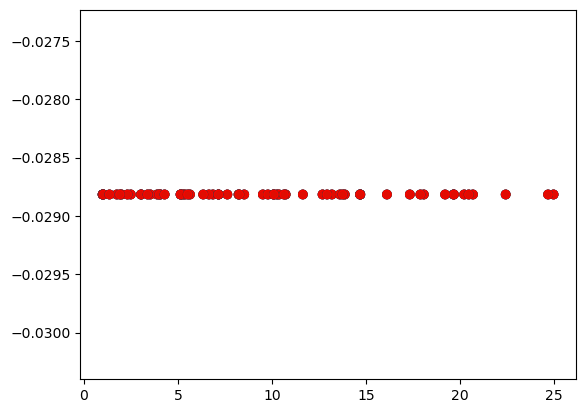

In [180]:
# Additionally color code by lag/window size combinations
plt.scatter(ccc_act_pairs[:, 1], ccc_act_pairs[:, 0], c=cols1, alpha=0.5)

# What acounts for the residual variation?

In [ ]:
# Conclusion: Overall canonical correlation between the 2 recordings is highest at zero lag, window size 1, and grows with the autocorrelation time of the signal 

### Direct regression analysis

In [193]:
# What is the raw r2 of prediction across the different preprocesing parameters? CCA doesn't do very well, because we try to compress down to 6 dimensions. Let's just do ambient regression. This dovetails nicely
# with a poisson GLM regressiona

In [8]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [8]:
lr2 = np.zeros(df.shape[0])

for i in tqdm(range(df.shape[0])):
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)

    x = StandardScaler().fit_transform(x)
    y = StandardScaler().fit_transform(y)

    linmodel = LinearRegression()
    linmodel.fit(x, y)
    
    lr2[i] = linmodel.score(x, y)

100%|██████████| 576/576 [27:21<00:00,  2.85s/it]


In [18]:
# 'win=2' corresponds to index 2, which if we refer to mpi_timescale_cca, refers to window size 1
#w1df = apply_df_filters(df, win=2)
w1df = apply_df_filters(df)
ccc_act_pairs = np.zeros((w1df.shape[0], 3))

lag_cols = ['r', 'g', 'b']
#win_markers = ['s', 't', 'o']
win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for i in range(w1df.shape[0]):
#    ccc = np.max(w1df.iloc[i]['cc_coefs'])
    ccf_df_ = apply_df_filters(ccf_df, didx=w1df.iloc[i]['didx'], bin_width=w1df.iloc[i]['bin_width'], filter_fn=w1df.iloc[i]['filter_fn'], filter_kwargs=w1df.iloc[i]['filter_kwargs'])
    assert(ccf_df_.shape[0] == 1)
    ccc_act_pairs[i, 0] = lr2[i]
    ccc_act_pairs[i, 1] = ccf_df_.iloc[0]['avg_act']
    ccc_act_pairs[i, 2] = ccf_df_.iloc[0]['median_act']

    cols1.append(lag_cols[lags.index(w1df.iloc[i]['lag'])])
    cols2.append(lag_cols[windows.index(w1df.iloc[i]['win'])])

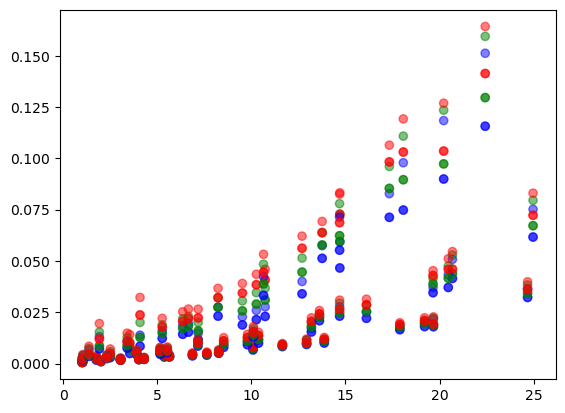

In [19]:
plt.scatter(ccc_act_pairs[:, 1], ccc_act_pairs[:, 0], c=cols1, alpha=0.5)


In [ ]:
# Project the M1 data onto the most predictable direction...
# How does one do that? Project onto top CCA vectors?

In [20]:
# Next plot of interest: What is the distribution of cross-correlations (?)

# Pairwise cross-correlation times M1/M1, S1, S1, M1/S1

In [24]:
# 8x8 set of boxplots

In [25]:
ccf_df.keys()

Index(['didx', 'bin_width', 'filter_fn', 'filter_kwargs', 'ccf', 'avg_act',
       'median_act'],
      dtype='object')

In [28]:
np.allclose(ccf_df.iloc[0]['ccf'][1].T, ccf_df.iloc[0]['ccf'][1])

False

In [37]:
rl = []
for i in tqdm(range(ccf_df.shape[0])):
    df_ = apply_df_filters(df, didx=ccf_df.iloc[i]['didx'], bin_width=ccf_df.iloc[i]['bin_width'], 
                               filter_fn=ccf_df.iloc[i]['filter_fn'], filter_kwargs=ccf_df.iloc[i]['filter_kwargs'])
    assert(ccf_df_.shape[0] == 1)


    with open(df_.iloc[0]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    M1shape = Y.shape[-1]
    S1shape = X.shape[-1]

    ccf = ccf_df.iloc[i]['ccf']

    cctM1 = []
    cctS1 = []
    cctM1S1 = []
    cctS1M1 = []

    for j in range(ccf.shape[1]):
        for k in range(ccf.shape[2]):
            if j == k:
                continue

            cct_index = np.argwhere(np.abs(ccf[:, j, k]) <= np.abs(1e-1 * ccf[0, j, k]))

            if j <= M1shape and k <= M1shape:                
                if len(cct_index) > 0:
                    cctM1.append(cct_index[0][0])
                else:
                    cctM1.append(ccf.shape[0])

            elif j > M1shape and k > M1shape:
                
                if len(cct_index) > 0:
                    cctS1.append(cct_index[0][0])
                else:
                    cctS1.append(ccf.shape[0])
                
            # Labeling is a bit ambiguous here
            elif j > M1shape:

                if len(cct_index) > 0:
                    cctM1S1.append(cct_index[0][0])
                else:
                    cctM1S1.append(ccf.shape[0])


            elif k > S1shape:

                if len(cct_index) > 0:
                    cctS1M1.append(cct_index[0][0])
                else:
                    cctS1M1.append(ccf.shape[0])

    r = {}
    r['fl'] = df_.iloc[0]['fl']
    r['cctM1'] = np.array(cctM1)
    r['cctS1'] = np.array(cctS1)
    r['cctM1S1'] = np.array(cctM1S1)
    r['cctS1M1'] = np.array(cctS1M1)
    rl.append(r)

100%|██████████| 64/64 [01:14<00:00,  1.16s/it]


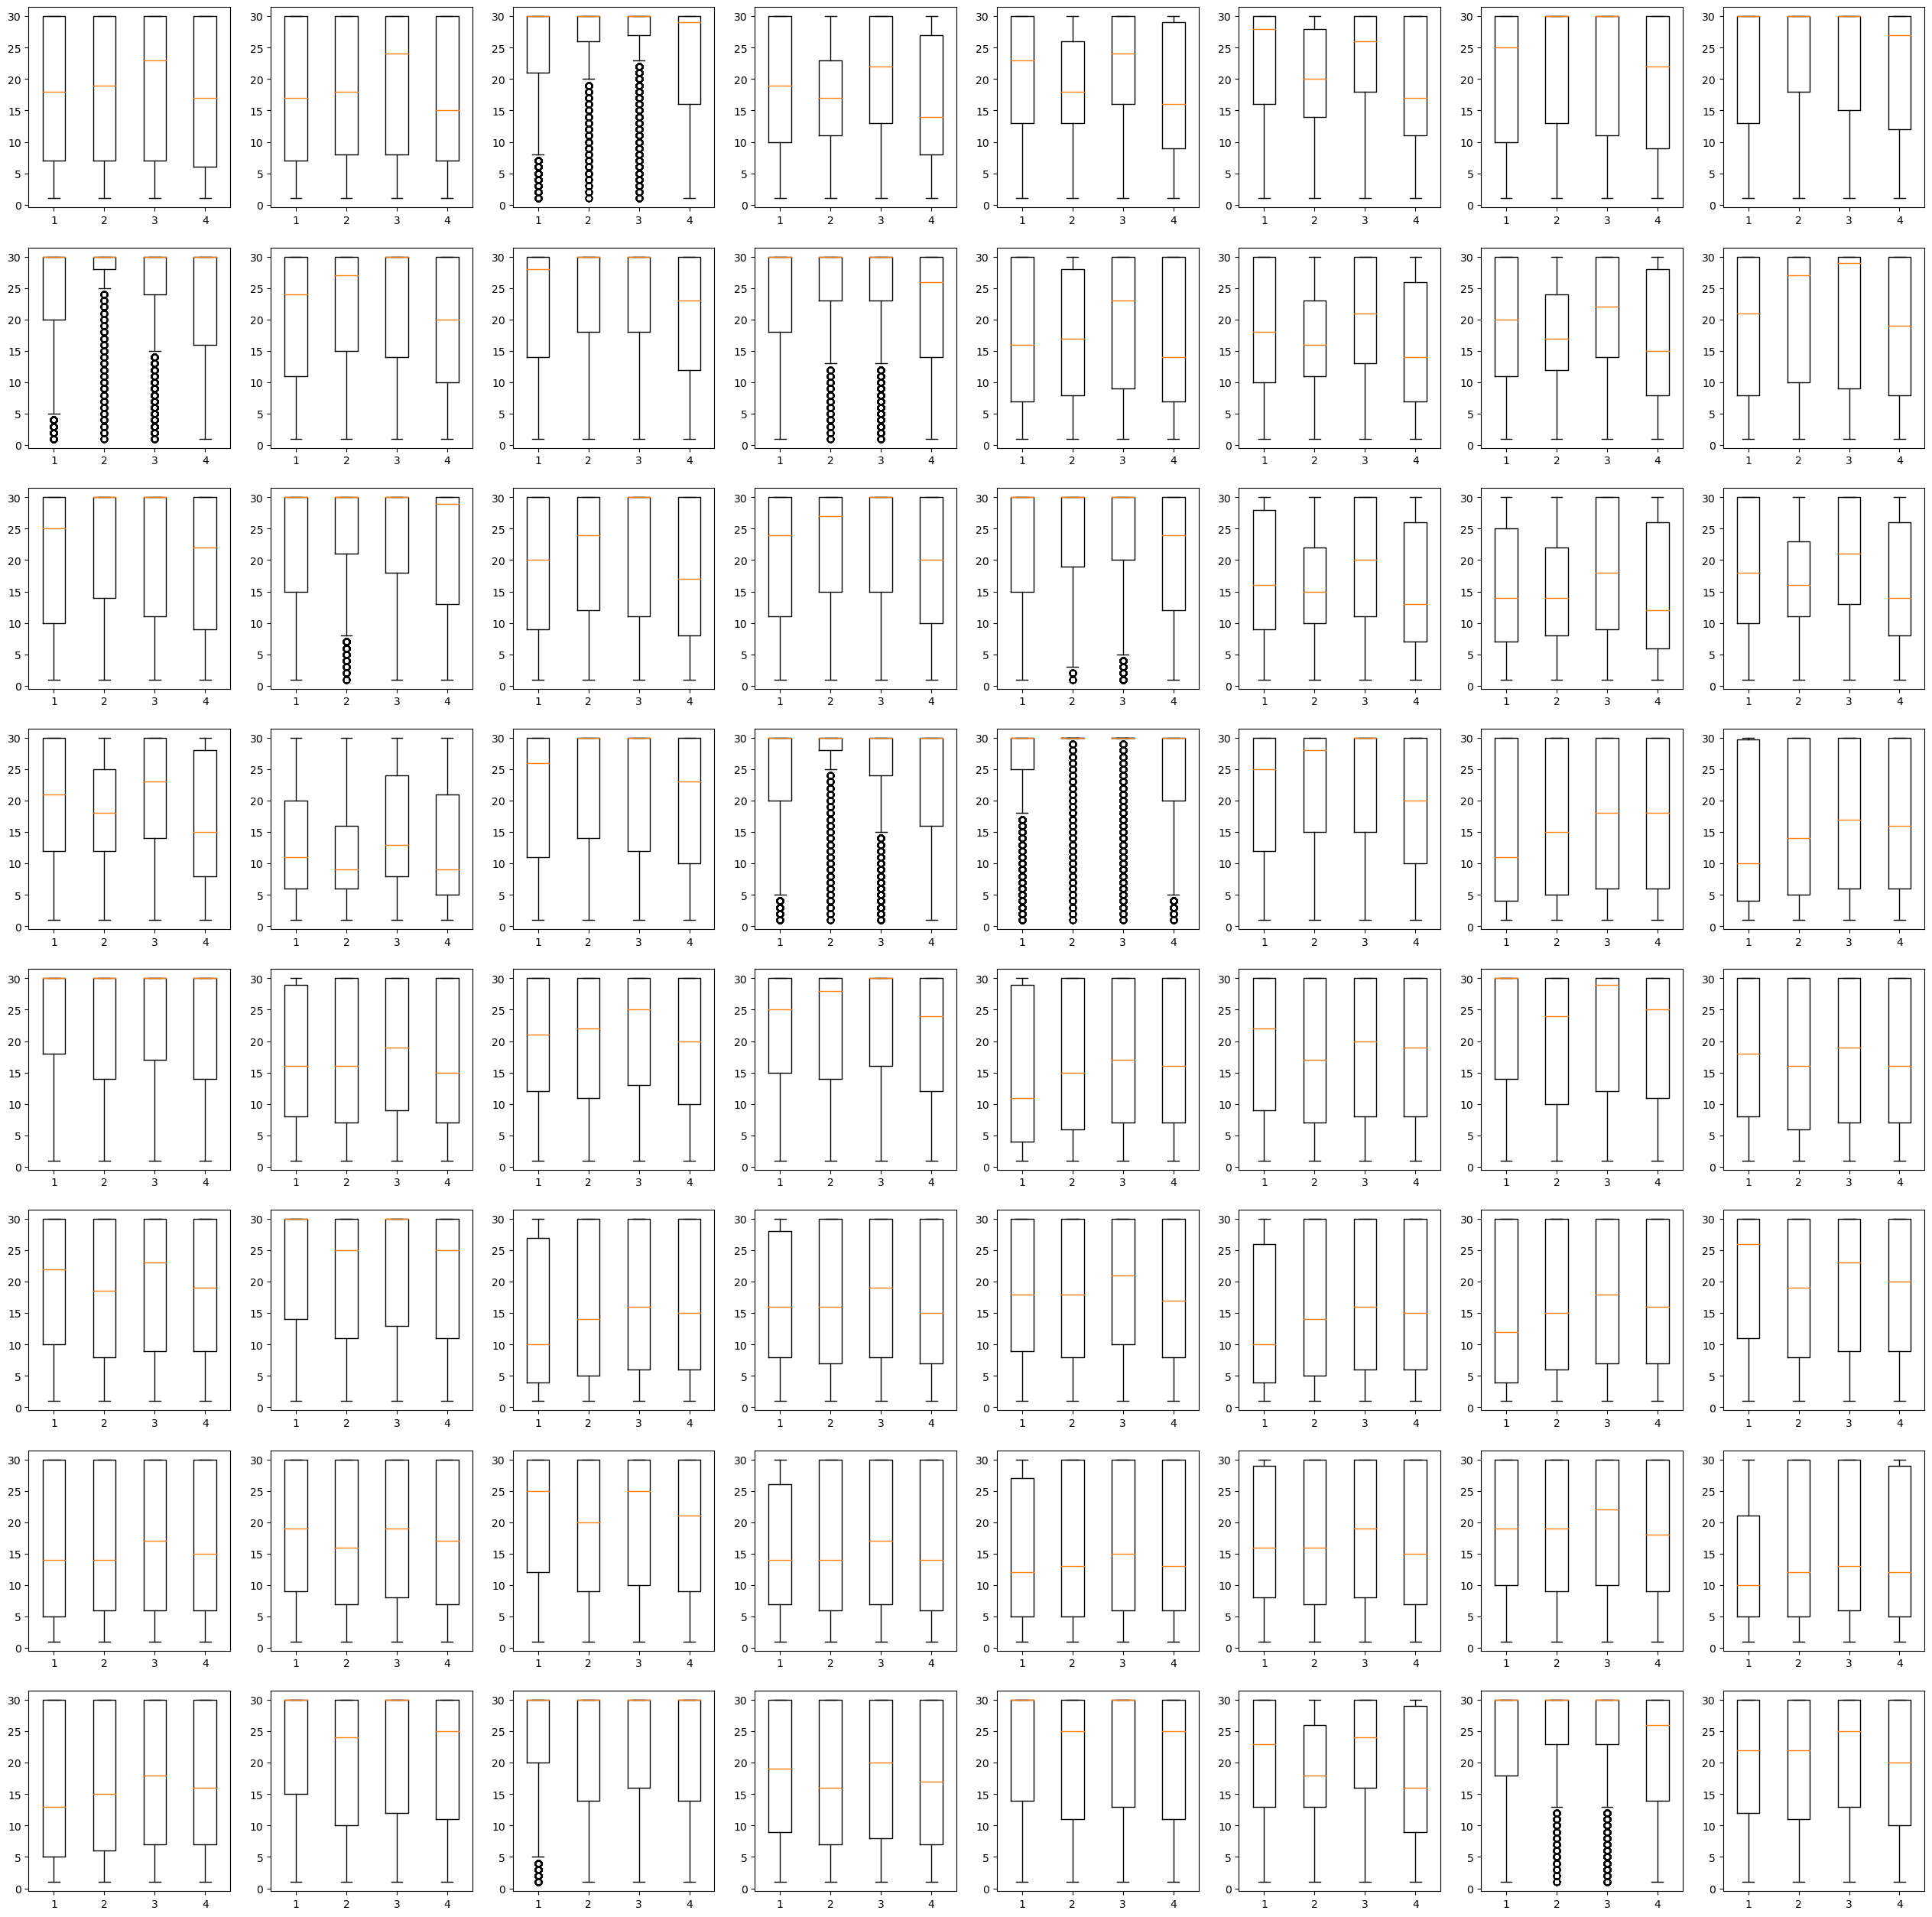

In [38]:
# 8 x 8 boxplots
fig, ax = plt.subplots(8, 8, figsize=(32, 32))

for i in range(len(rl)):
    a = ax[np.unravel_index(i, (8, 8))]
    r = rl[i]
    a.boxplot([r['cctM1'], r['cctS1'], r['cctM1S1'], r['cctS1M1']])

In [39]:
# Possible analysis: Using pre-processing parameters that don't saturate at 30, look at pairs of neurons with high
# 

In [40]:
# What is the predictive power of S1 onto the top n cca components?

In [41]:
df.iloc[0]

didx                                                             0
bin_width                                                        5
filter_fn                                                     none
filter_kwargs                                                   {}
lag                                                              4
win                                                              0
ccamodel                                       CCA(n_components=6)
fl               /mnt/Secondary/data/sabes_tmp/didx_0_loader_id...
cc_coefs         [0.19775543603246445, 0.07888587526980315, 0.0...
r2_scores                                                -0.028816
Name: 0, dtype: object

In [43]:
lr2_cc = np.zeros((df.shape[0], 6))

for i in tqdm(range(df.shape[0])):
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)

    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)

    x = StandardScaler().fit_transform(x)
    for d in range(1, 7):
        y = StandardScaler().fit_transform(Y_c)[:, 0:d]

        linmodel = LinearRegression()
        linmodel.fit(x, y)
        
        lr2_cc[i, d-1] = linmodel.score(x, y)

100%|██████████| 576/576 [51:16<00:00,  5.34s/it]


In [44]:
with open('m1s1_regression.dat', 'wb') as f:
    f.write(pickle.dumps(lr2))
    f.write(pickle.dumps(lr2_cc))

In [58]:
# Plot the r2 vs. dimension
# 'win=2' corresponds to index 2, which if we refer to mpi_timescale_cca, refers to window size 1
#w1df = apply_df_filters(df, win=2)
w1df = apply_df_filters(df)
ccc_act_pairs = np.zeros((w1df.shape[0], 3))

lag_cols = ['r', 'g', 'b']
#win_markers = ['s', 't', 'o']
win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for i in range(w1df.shape[0]):
#    ccc = np.max(w1df.iloc[i]['cc_coefs'])
    ccc = w1df.iloc[0]['r2_scores']
    ccf_df_ = apply_df_filters(ccf_df, didx=w1df.iloc[i]['didx'], bin_width=w1df.iloc[i]['bin_width'], filter_fn=w1df.iloc[i]['filter_fn'], filter_kwargs=w1df.iloc[i]['filter_kwargs'])
    assert(ccf_df_.shape[0] == 1)
    ccc_act_pairs[i, 0] = lr2_cc[i, -2]
    ccc_act_pairs[i, 1] = ccf_df_.iloc[0]['avg_act']
    ccc_act_pairs[i, 2] = ccf_df_.iloc[0]['median_act']

    cols1.append(lag_cols[lags.index(w1df.iloc[i]['lag'])])
    cols2.append(lag_cols[windows.index(w1df.iloc[i]['win'])])

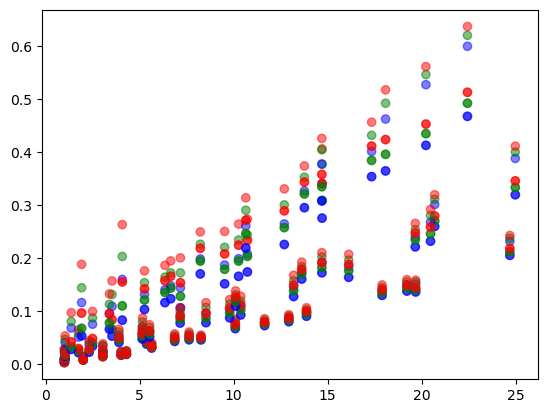

In [57]:
plt.scatter(ccc_act_pairs[:, 1], ccc_act_pairs[:, 0], c=cols1, alpha=0.5)


In [60]:
np.max(lr2_cc, axis=0)

array([0.86040743, 0.82433279, 0.75909007, 0.71321485, 0.67521948,
       0.63765622])

### Subspace analysis

In [ ]:
# predictability monotonically decreases

In [61]:
# One queston one should resolve is whether the most predictable direction is given by CCA. In the communication subspace paper, one uses factor analysis to
# resolve this question, but this is geared towards explanations of variance

In [62]:
# Subsequent question: What is the subspace angle relationship of the canonical correlation vectors to the subspace methods? 
# How predictable are the subspace dynamics (linearly, or GLM) from S1 activity?

In [30]:
argfiles = glob.glob('/mnt/Secondary/data/timescale_dimreduc/arg*dat')

In [31]:
rl = []
for argfile in argfiles:
    with open(argfile, 'rb') as f:
        args = pickle.load(f)
    argno = argfile.split('arg')[1].split('.dat')[0]
    r = {}
    r['rf'] = args['results_file']
    r['data_file'] = args['data_file']
    r['dr_method'] = args['task_args']['dimreduc_method']
    r['dr_args'] = args['task_args']['dimreduc_args']
    rl.append(r)

In [32]:
ref_df = pd.DataFrame(rl)

In [69]:
# Use the ref_df to answer the following questions:
# (1) What is the subspace angle relationship between the subspace methods and the top canonical correlation vectors?
# (2) How predictable are the subspaces from the S1 activity?

In [20]:
# Restrict to window length 1
dfw1 = apply_df_filters(df, win=1)

# N unique cca fits x dr types x folds x dims
ssa_avg = np.zeros((dfw1.shape[0], 4, 5, 3))
ssa_min = np.zeros((dfw1.shape[0], 4, 5, 3))

for i in tqdm(range(dfw1.shape[0])):
    with open(dfw1.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = dfw1.iloc[i]['lag']
    w = dfw1.iloc[i]['win']

    model = dfw1.iloc[i]['ccamodel']

    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)

    Vcca = model.y_weights_

    if len(drdf) > 0:
        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                try:
                    d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)+
                except:
                    pdb.set_trace()
                assert(d_.shape[0] == 1)
                Vpca = d_.iloc[0]['coef']
                ssangles = scipy.linalg.subspace_angles(Vpca, Vcca)
                ssa_avg[i, 0, fold, didx] = np.mean(ssangles)
                ssa_min[i, 0, fold, didx] = np.min(ssangles)

    else:
        ssa_avg[i, 0] = np.nan
        ssa_min[i, 0] = np.nan

    lqgdf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='LQGCA')
    assert(lqgdf.shape[0] == 3)

    # Keep consistent ordering of dimreduc args
    drargs = [{'T':3, 'loss_type':'trace', 'n_init':10}, {'T':1, 'loss_type':'trace', 'n_init':10},
              {'T':6, 'loss_type':'trace', 'n_init':10}]

    for j in range(3): 
        lqgdf_ = apply_df_filters(lqgdf, dr_args=drargs[j])
        with open(lqgdf_.iloc[0]['rf'], 'rb') as f:
            results = pickle.load(f)

        drdf = pd.DataFrame(results)

        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                try:
                    d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                    Vlqg = d_.iloc[0]['coef']
                    ssangles = scipy.linalg.subspace_angles(Vlqg, Vcca)
                    ssa_avg[i, j + 1, fold, didx] = np.mean(ssangles)
                    ssa_min[i, j + 1, fold, didx] = np.min(ssangles)    
                except:
                    ssa_avg[i, j + 1, fold, didx] = np.nan
                    ssa_min[i, j + 1, fold, didx] = np.nan    
            

100%|██████████| 192/192 [02:53<00:00,  1.11it/s]


In [38]:
np.nanmean(ssa_min[:, 0, :, 2], axis=1)

/tmp/ipykernel_15416/1655885650.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(ssa_min[:, 0, :, 2], axis=1)


array([0.92986585, 0.96290946, 0.93922758, 0.69472795, 0.68179959,
       0.63779274, 0.65668463, 0.64133634, 0.6283691 , 0.69534108,
       0.63906955, 0.59796795, 0.61230136, 0.57343324, 0.54014028,
       0.62876727, 0.59306405, 0.56111628, 0.68900839, 0.67159859,
       0.63659303, 0.67558452, 0.63306124, 0.59614801, 0.70932189,
       0.67404841, 0.63926306, 0.71809059, 0.68221101, 0.60158264,
       0.75540589, 0.71744263, 0.65247896, 0.70075465, 0.68428673,
       0.66725902, 0.68175061, 0.6743042 , 0.55086674, 0.72282572,
       0.66405325, 0.62389157, 0.63815666, 0.5922225 , 0.55423937,
       0.73285481, 0.73079377, 0.71006559, 0.6864947 , 0.66357295,
       0.62773713, 0.69572933, 0.65100541, 0.61035707, 0.68105415,
       0.66815343, 0.58617423, 0.73802002, 0.69584765, 0.61311557,
       0.72899319, 0.71610494, 0.67910109, 0.77095047, 0.69005066,
       0.64665912, 0.82279132, 0.67584143, 0.5757227 , 0.70743896,
       0.65091348, 0.60987683, 0.62592561, 0.58154931, 0.54275

In [39]:
np.nanmean(ssa_min[:, 0, :, 0], axis=1)

/tmp/ipykernel_15416/3034538531.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(ssa_min[:, 0, :, 0], axis=1)


array([0.96106229, 0.99296717, 0.97436235, 0.71676296, 0.69794207,
       0.65360821, 0.73035717, 0.70627126, 0.68649369, 0.82046465,
       0.72235398, 0.6585337 , 0.8200327 , 0.7374306 , 0.67381524,
       0.80884548, 0.74485046, 0.69279197, 0.70347048, 0.6872435 ,
       0.65305108, 0.70433238, 0.66635711, 0.63086166, 0.74234617,
       0.71242384, 0.67890414, 0.74879056, 0.70940545, 0.62303064,
       0.80806271, 0.75361717, 0.68218176, 0.73381717, 0.71010125,
       0.68210068, 0.70628838, 0.68822758, 0.56012599, 0.81441403,
       0.71882266, 0.65834665, 0.82452764, 0.73209047, 0.65905702,
       0.74537961, 0.74414   , 0.72681841, 0.70112389, 0.67903318,
       0.64407933, 0.72577205, 0.68598248, 0.64730325, 0.70476474,
       0.68690367, 0.6011066 , 0.76992682, 0.72506262, 0.63702546,
       0.74729001, 0.72843984, 0.69072342, 0.81004972, 0.71132154,
       0.65656399, 0.87944941, 0.72805635, 0.58351815, 0.82104404,
       0.72217767, 0.65988277, 0.83406237, 0.7405033 , 0.66755

In [ ]:
# Unclear if the above will be statistically significant

In [59]:
# For dimensions 2-6, perform a cross-validated regression from S1 activity to the projected activity of each of the methods.
# This has no interaction with cca. Therefore, remove the iteration over windows

# N unique cca fits x dr types x folds x dims
subspace_r2 = np.zeros((dfw1.shape[0], 4, 5, 3))


for i in tqdm(range(dfw1.shape[0])):
    with open(dfw1.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()
    lag = dfw1.iloc[i]['lag']
    w = dfw1.iloc[i]['win']

    model = dfw1.iloc[i]['ccamodel']

    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)

    Vcca = model.y_weights_

    # For each fold, and dimensions 2-6, measure the min and average subspace angle
    for fold in range(5):
        for didx, dim in enumerate(np.array([2, 4, 6])):
            try:
                d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                assert(d_.shape[0] == 1)
            except:
                subspace_r2[i, 0, fold, didx] = np.nan
                continue

            Vpca = d_.iloc[0]['coef']

            ytrain = Y[d_.iloc[0]['train_idxs']] @ Vpca
            ytest = Y[d_.iloc[0]['test_idxs']] @ Vpca

            xtrain = X[d_.iloc[0]['train_idxs']]
            xtest = X[d_.iloc[0]['test_idxs']]

            # Apply window and lag relative to each other
            if lag != 0:
                xtrain = xtrain[:-lag, :]
                ytrain = ytrain[lag:, :]

                xtest = xtest[:-lag, :]
                ytest = ytest[lag:, :]

            ytrain = StandardScaler().fit_transform(ytrain)
            xtrain = StandardScaler().fit_transform(xtrain)

            ytest = StandardScaler().fit_transform(ytest)
            xtest = StandardScaler().fit_transform(xtest)

            linmodel = LinearRegression()
            linmodel.fit(xtrain, ytrain)
            subspace_r2[i, 0, fold, didx] = linmodel.score(xtest, ytest)

    lqgdf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='LQGCA')
    assert(lqgdf.shape[0] == 3)

    # Keep consistent ordering of dimreduc args
    drargs = [{'T':3, 'loss_type':'trace', 'n_init':10}, {'T':1, 'loss_type':'trace', 'n_init':10},
              {'T':6, 'loss_type':'trace', 'n_init':10}]

    for j in range(3): 
        lqgdf_ = apply_df_filters(lqgdf, dr_args=drargs[j])
        with open(lqgdf_.iloc[0]['rf'], 'rb') as f:
            results = pickle.load(f)

        drdf = pd.DataFrame(results)
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                try:
                    d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                    assert(d_.shape[0] == 1)
                except:
                    subspace_r2[i, j + 1, fold, didx] = np.nan
                    continue

                Vlqg = d_.iloc[0]['coef']

                ytrain = Y[d_.iloc[0]['train_idxs']] @ Vlqg
                ytest = Y[d_.iloc[0]['test_idxs']] @ Vlqg

                xtrain = X[d_.iloc[0]['train_idxs']]
                xtest = X[d_.iloc[0]['test_idxs']]

                # Apply window and lag relative to each other
                if lag != 0:
                    xtrain = xtrain[:-lag, :]
                    ytrain = ytrain[lag:, :]

                    xtest = xtest[:-lag, :]
                    ytest = ytest[lag:, :]

                ytrain = StandardScaler().fit_transform(ytrain)
                xtrain = StandardScaler().fit_transform(xtrain)

                ytest = StandardScaler().fit_transform(ytest)
                xtest = StandardScaler().fit_transform(xtest)

                linmodel = LinearRegression()
                linmodel.fit(xtrain, ytrain)    
                subspace_r2[i, j + 1, fold, didx] = linmodel.score(xtest, ytest)

    # For dimensions 2-6, perform a cross-validated regression from S1 activity to the projected activity of each of the methods.
    # This has no interaction with cca
    

100%|██████████| 192/192 [1:57:39<00:00, 36.77s/it]


In [ ]:
np.nanmean(subspace_r2[:, 0, :, 0])

In [58]:
np.nanmean(subspace_r2[:, 1, :, 1])

0.0612166256203374

In [ ]:
plt.hist(np.nanmean(subspace_r2[:, 0, 0]))

In [40]:
# What one should visualize is whether the resulting r2 depend on lag, and how they change during the course of a reach

In [6]:
# with open('s1_subspace_regression.pkl', 'wb') as f:
#     f.write(pickle.dumps(subspace_r2))
with open('s1_subspace_regression.pkl', 'rb') as f:
    subspace_r2 = pickle.load(f)

In [18]:
# Match up with the autocorrelation times
w1df = apply_df_filters(df, win=1)
act = np.zeros(w1df.shape[0])

lags = list(np.unique(w1df['lag'].values))
lag_cols = ['r', 'g', 'b']
#win_markers = ['s', 't', 'o']
win_cols = ['r', 'g', 'b']

cols1 = []
for i in range(w1df.shape[0]):
#    ccc = np.max(w1df.iloc[i]['cc_coefs'])
    ccf_df_ = apply_df_filters(ccf_df, didx=w1df.iloc[i]['didx'], bin_width=w1df.iloc[i]['bin_width'], filter_fn=w1df.iloc[i]['filter_fn'], filter_kwargs=w1df.iloc[i]['filter_kwargs'])
    assert(ccf_df_.shape[0] == 1)
    act[i] = ccf_df_.iloc[0]['avg_act']

    cols1.append(lag_cols[lags.index(w1df.iloc[i]['lag'])])

/tmp/ipykernel_31582/2664664947.py:2: RuntimeWarning: Mean of empty slice
  plt.scatter(act, np.nanmean(subspace_r2[:, 1, :, 2], axis=1), c=cols1)


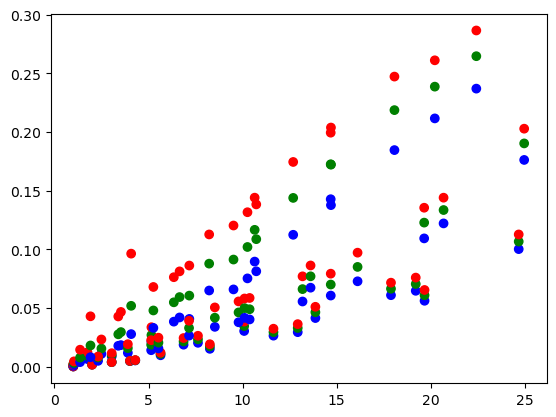

In [39]:
#plt.scatter(act, np.nanmean(subspace_r2[:, 0, :, 2], axis=1), c=cols1)
plt.scatter(act, np.nanmean(subspace_r2[:, 1, :, 2], axis=1), c=cols1)

In [34]:
# Restrict to window length 1
dfw1 = apply_df_filters(df, win=1)

# N unique cca fits x dr types x folds x dims
method_ssa_avg = np.zeros((dfw1.shape[0], 5, 3))
method_ssa_min = np.zeros((dfw1.shape[0], 5, 3))

for i in tqdm(range(dfw1.shape[0])):
    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf_pca = pd.DataFrame(results)
    lqgdf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='LQGCA', dr_args={'T':3, 'loss_type':'trace', 'n_init':10})
    assert(lqgdf.shape[0] == 1)
    with open(lqgdf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)
    drdf_lqg = pd.DataFrame(results)

    if len(drdf_pca) > 0 and len(drdf_lqg) > 0:
        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):

                d_pca = apply_df_filters(drdf_pca, dim=dim, fold_idx=fold)
                d_lqg = apply_df_filters(drdf_lqg, dim=dim, fold_idx=fold)
                assert(d_pca.shape[0] == 1)
                assert(d_lqg.shape[0] == 1)
                Vpca = d_pca.iloc[0]['coef']
                Vlqg = d_lqg.iloc[0]['coef']

                ssangles = scipy.linalg.subspace_angles(Vpca, Vlqg)
                method_ssa_avg[i, fold, didx] = np.mean(ssangles)
                method_ssa_min[i, fold, didx] = np.min(ssangles)

    else:
        method_ssa_avg[i] = np.nan
        method_ssa_min[i] = np.nan

100%|██████████| 192/192 [00:44<00:00,  4.27it/s]


/tmp/ipykernel_31582/412720857.py:1: RuntimeWarning: Mean of empty slice
  plt.scatter(act, np.nanmean(method_ssa_avg[:, :, 2], axis=1))


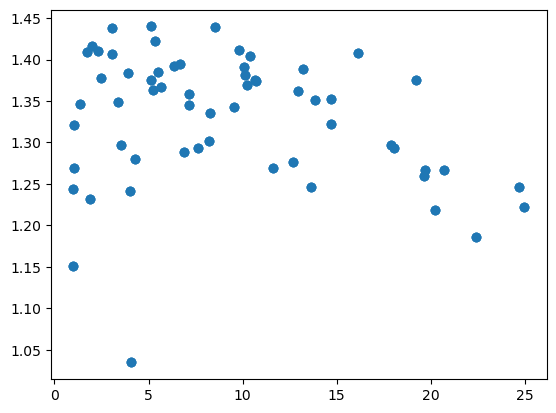

In [35]:
plt.scatter(act, np.nanmean(method_ssa_avg[:, :, 2], axis=1))

In [ ]:
# Recall that we decided we would look at modulations over the timecourse of a reach. Repeat the above exercise accordingly

In [ ]:
# Next step is to simplify and consolidate. Choose a subset of the